In [1]:
from scipy import io
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import os.path as osp
import os
from tsnecuda import TSNE
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fp = '/datasets/dsc180a-wi20-public/Malware/group_data/group_02/sensitive_data'

In [3]:
g = io.loadmat(osp.join(fp, 'interim', 'graph','graph_1.mat'))
y_hateful = g['post_label'].reshape(-1,)
y_community_controversial = (~g['post_cate'][:, -1].astype(bool)).astype(int)
y_community_subreddit = np.array(g['post_cate'][:, :-1].argmax(1)).reshape(-1,)

In [4]:
def evaluate_emb(X_train, X_test, y_train, y_test, binary):
    clf = LogisticRegression(
        verbose=False, max_iter=2000, class_weight = 'balanced', n_jobs=8, solver = 'lbfgs')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_true = y_test.copy()
    if binary:
        tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
        acc = metrics.accuracy_score(y_true, y_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label = 1)
        auc = metrics.auc(fpr, tpr)
        precision = metrics.precision_score(y_true, y_pred)
        recall = metrics.recall_score(y_true, y_pred)
        return tn, fp, fn, tp, acc, auc, precision, recall
    else:
        acc = metrics.accuracy_score(y_true, y_pred)
        return acc
def plot_embedding(embd, hateful, controversial, subreddit, embed_type, graph):
    if embed_type == 'infomax':
        return
    print('TSNE plot for the embedding')
    tsne = TSNE(n_components=2, perplexity=15, learning_rate=10)
    node_embeddings_2d = tsne.fit_transform(embd)
    fig = plt.figure(figsize=(16, 16))
    print('embedding seperated by hateful posts')
    for i in range(2):
        plt.scatter(node_embeddings_2d[hateful == i, 0], node_embeddings_2d[hateful == i, 1], s=10, label = i)
    plt.title('hateful post vs. normal post in {} embedding for {}'.format(embed_type, graph))
    plt.legend()
    plt.axis('off')
    plt.show()
    fig = plt.figure(figsize=(16, 16))
    print('embedding seperated by controversial communities')
    for i in range(2):
        plt.scatter(node_embeddings_2d[controversial == i, 0], node_embeddings_2d[controversial == i, 1], s=10, label = i)
    plt.title('controversial community vs. normal community in {} embedding for {}'.format(embed_type, graph))
    plt.legend()
    plt.axis('off')
    plt.show()
    fig = plt.figure(figsize=(16, 16))
    print('embedding seperated by subreddits')
    for i in range(subreddit.max() + 1):
        plt.scatter(node_embeddings_2d[subreddit == i, 0], node_embeddings_2d[subreddit == i, 1], s=10, label = i)
    plt.title('subreddits in {} embedding for {}'.format(embed_type, graph))
    plt.legend()
    plt.axis('off')
    plt.show()
    return node_embeddings_2d
def plot_loss(arry, graph, embed):
    if arry.ndim == 1:
        plt.title('training loss curve for {} {} embedding'.format(graph, embed))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        pd.Series(arry).plot()
        plt.show()
    elif arry.ndim == 2:
        lst = pd.Series(np.ndarray.flatten(arry))
        lst.index = lst.index/(len(lst)/5)
        plt.title('training loss curve for {} {} embedding'.format(graph, embed))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        lst.plot()
        plt.show()

In [9]:
def evaluate_embedding(fp):
    g = io.loadmat(osp.join(fp, 'interim', 'graph','graph_1.mat'))
    y_hateful = g['post_label'].reshape(-1,)
    y_community_controversial = (~g['post_cate'][:, -1].astype(bool)).astype(int)
    y_community_subreddit = np.array(g['post_cate'][:, :-1].argmax(1)).reshape(-1,)
    train_mask, test_mask = train_test_split(np.arange(len(y_hateful)), test_size=0.2)
    
    y_hateful_train, y_hateful_test = y_hateful[train_mask], y_hateful[test_mask]
    y_community_controversial_train, y_community_controversial_test = y_community_controversial[train_mask],\
                                                                      y_community_controversial[test_mask]
    y_community_subreddit_train, y_community_subreddit_test = y_community_subreddit[train_mask],\
                                                              y_community_subreddit[test_mask]
    
    res = pd.DataFrame(index = ['hateful_post_tn', 'hateful_post_fp', 'hateful_post_fn', 'hateful_post_tp',
                                  'hateful_post_acc', 'hateful_post_auc', 'hateful_post_precision', 'hateful_post_recall',
                                  'controversial_community_tn', 'controversial_community_fp',
                                  'controversial_community_fn', 'controversial_community_tp',
                                  'controversial_community_acc', 'controversial_community_auc',
                                  'controversial_community_precision', 'controversial_community_recall',
                                  'subreddit_community_acc'])
    for graph in ['graph_1', 'graph_2']:
        print('evaluating embeddings for {}'.format(graph))
        for embeds in ['node2vec', 'metapath2vec', 'infomax']:
            print('evaluating {} embedding for {}'.format(embeds, graph))
            embedding = np.load(osp.join(fp, 'processed', embeds,  graph+'.npy')).astype(float)
            loss_log = np.array(json.load(open(osp.join(fp, 'processed', embeds, graph+'.npylog.json')))['loss'])
            print('training loss curve')
            plot_loss(loss_log, graph, embeds)
            tsne = plot_embedding(embedding, y_hateful, y_community_controversial, y_community_subreddit, embeds, graph)
            if embeds != 'infomax':
                np.save(osp.join(fp, 'processed', embeds, graph+'tsne.npy'), tsne)
            X_train, X_test = embedding[train_mask], embedding[test_mask]
            h_tn, h_fp, h_fn, h_tp, h_acc, h_auc, h_precision, h_recall = evaluate_emb(X_train, X_test, 
                                                                                       y_hateful_train, 
                                                                                       y_hateful_test, True)
            if embeds != 'infomax':
                c_tn, c_fp, c_fn, c_tp, c_acc, c_auc, c_precision, c_recall = evaluate_emb(X_train, X_test,y_community_controversial_train,y_community_controversial_test,True)

                s_acc = evaluate_emb(X_train, X_test, y_community_subreddit_train, y_community_subreddit_test, False)
            else:
                c_tn, c_fp, c_fn, c_tp, c_acc, c_auc, c_precision, c_recall = np.NaN, np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN
                s_acc = np.NaN
            res[graph + ':' + embeds] = ([h_tn, h_fp, h_fn, h_tp, h_acc, h_auc, h_precision, h_recall,
                        c_tn, c_fp, c_fn, c_tp, c_acc, c_auc, c_precision, c_recall,
                        s_acc])
            display(res[graph+':'+embeds])
    return res
            

evaluating embeddings for graph_1
evaluating node2vec embedding for graph_1
training loss curve


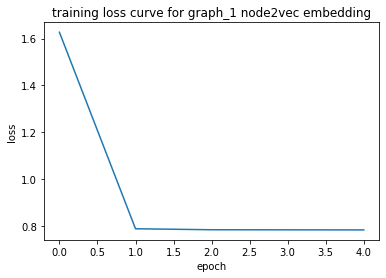

TSNE plot for the embedding
embedding seperated by hateful posts


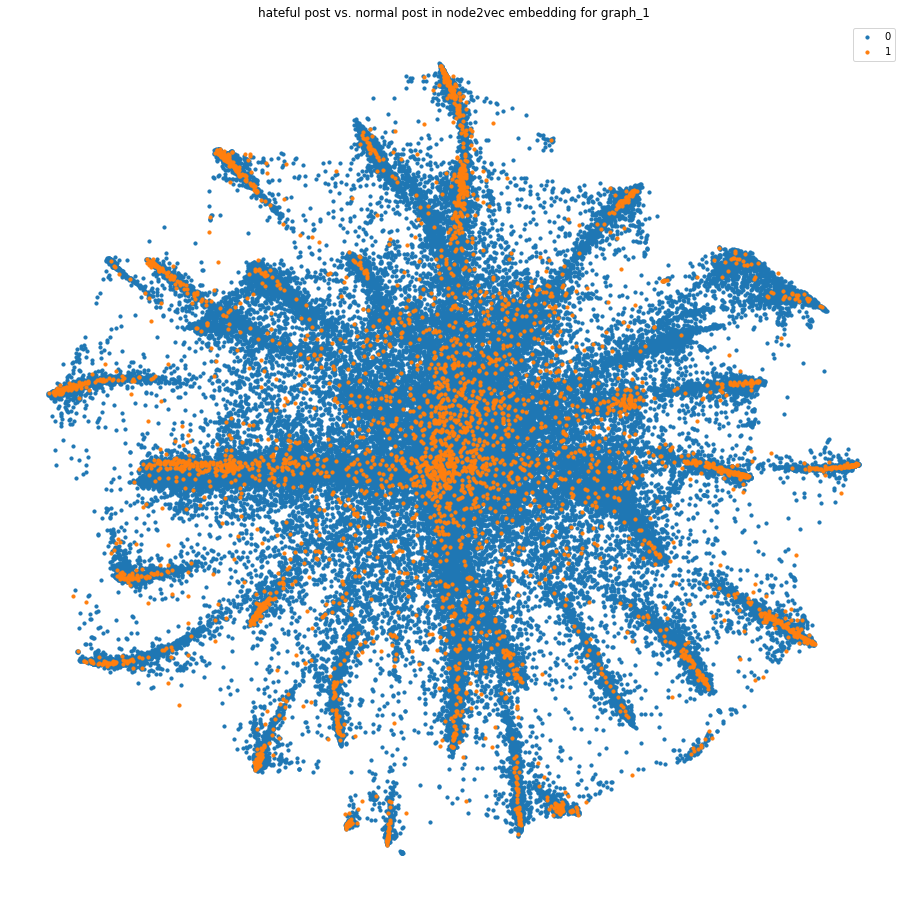

embedding seperated by controversial communities


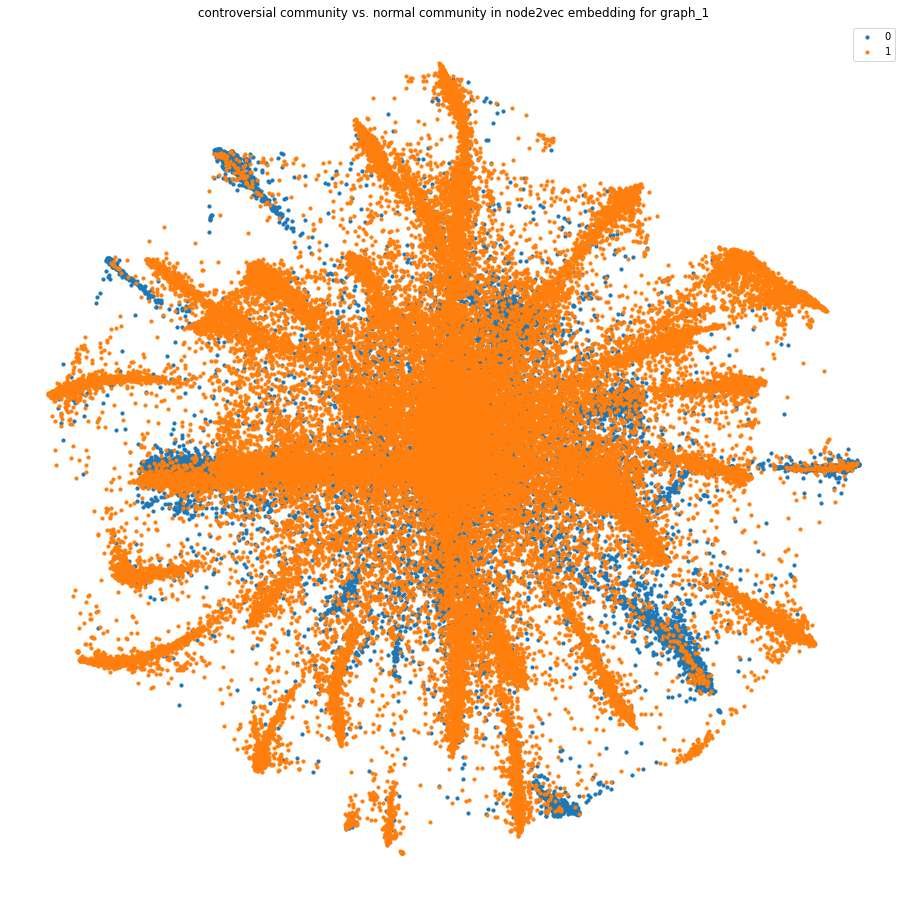

embedding seperated by subreddits


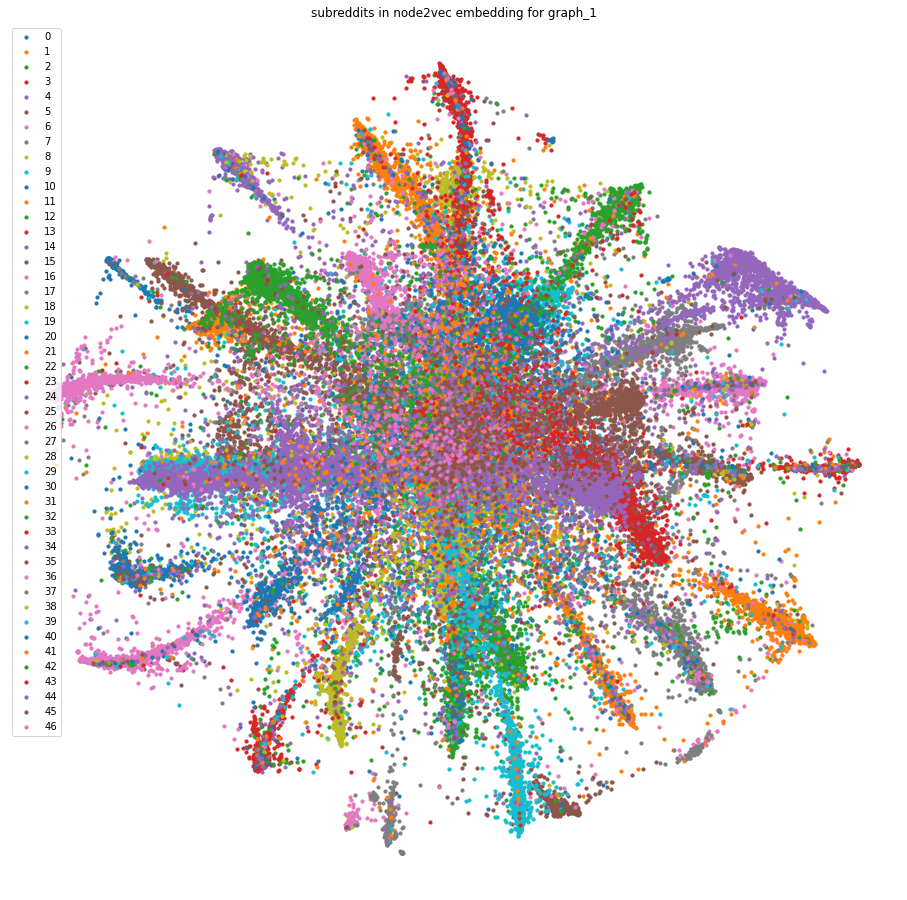

hateful_post_tn                      11963.000000
hateful_post_fp                       7848.000000
hateful_post_fn                        398.000000
hateful_post_tp                        474.000000
hateful_post_acc                         0.601315
hateful_post_auc                         0.573717
hateful_post_precision                   0.056957
hateful_post_recall                      0.543578
controversial_community_tn            3811.000000
controversial_community_fp             895.000000
controversial_community_fn            2835.000000
controversial_community_tp           13142.000000
controversial_community_acc              0.819659
controversial_community_auc              0.816187
controversial_community_precision        0.936240
controversial_community_recall           0.822557
subreddit_community_acc                  0.805154
Name: graph_1:node2vec, dtype: float64

evaluating metapath2vec embedding for graph_1
training loss curve


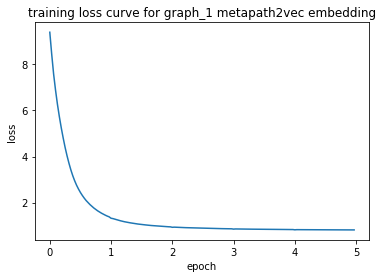

TSNE plot for the embedding
embedding seperated by hateful posts


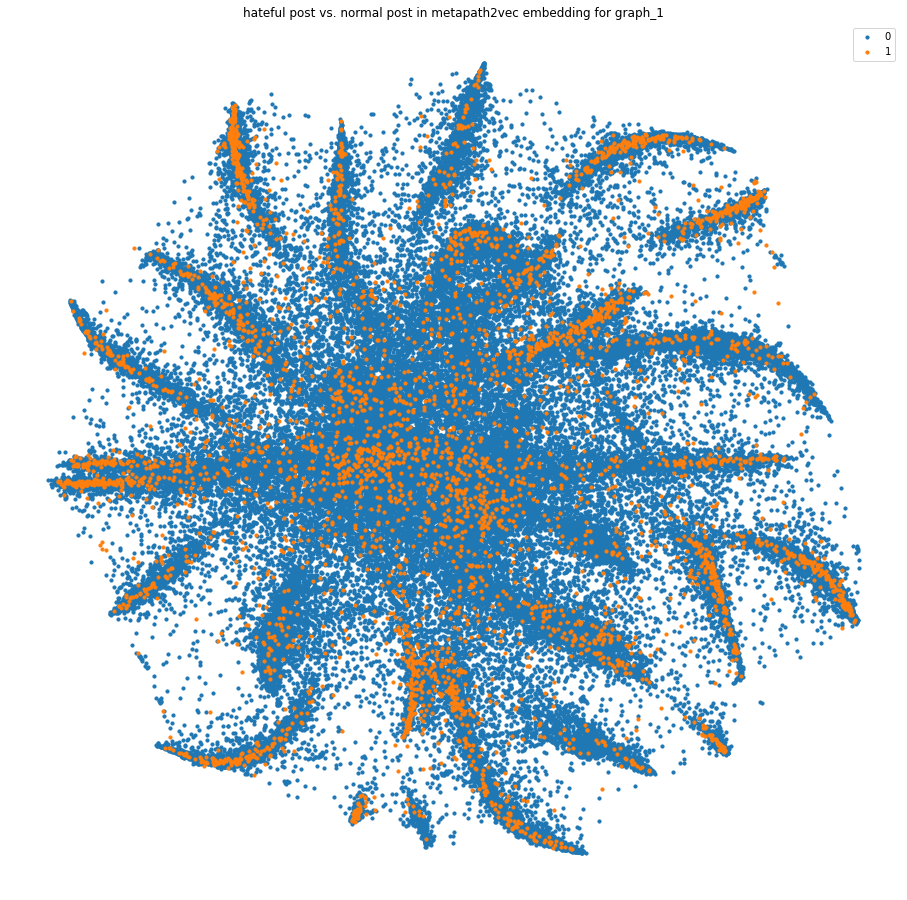

embedding seperated by controversial communities


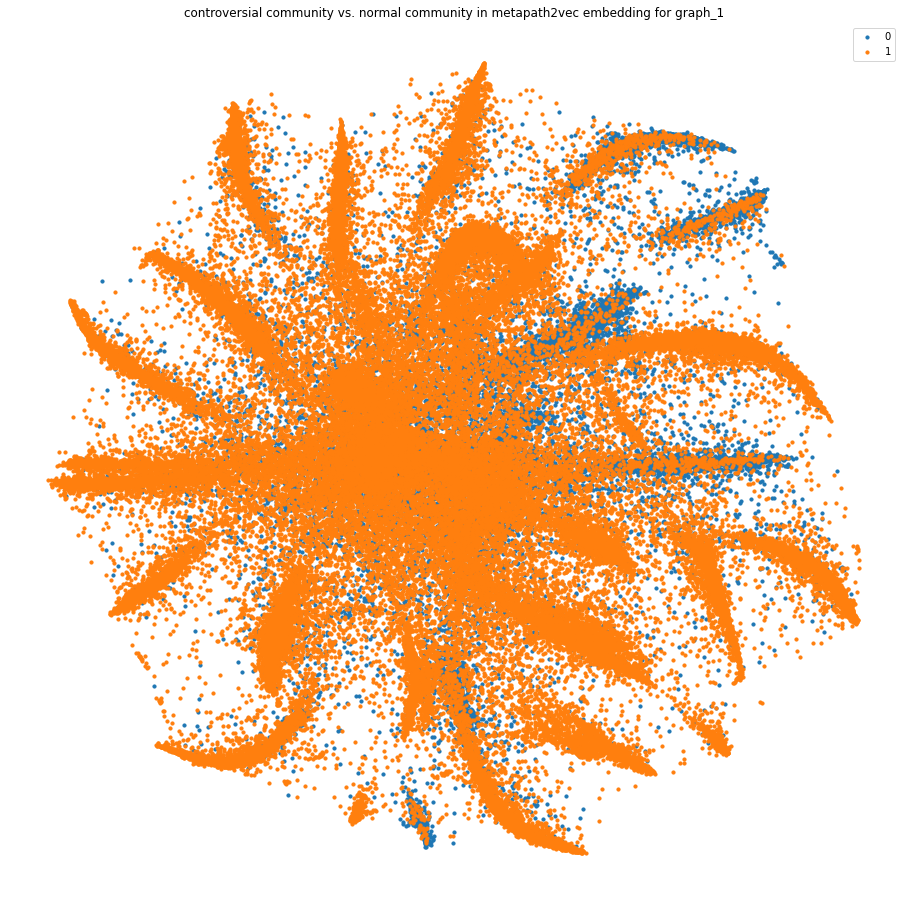

embedding seperated by subreddits


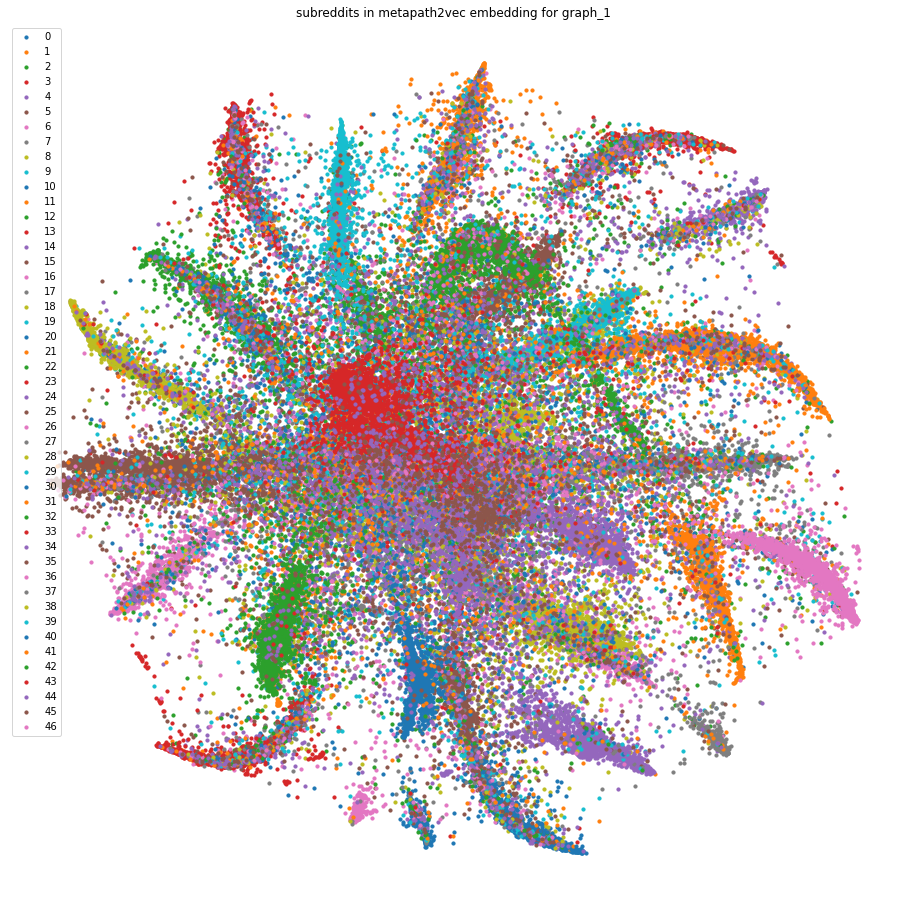

hateful_post_tn                      11838.000000
hateful_post_fp                       7973.000000
hateful_post_fn                        400.000000
hateful_post_tp                        472.000000
hateful_post_acc                         0.595175
hateful_post_auc                         0.569416
hateful_post_precision                   0.055891
hateful_post_recall                      0.541284
controversial_community_tn            3426.000000
controversial_community_fp            1280.000000
controversial_community_fn            3366.000000
controversial_community_tp           12611.000000
controversial_community_acc              0.775371
controversial_community_auc              0.758664
controversial_community_precision        0.907854
controversial_community_recall           0.789322
subreddit_community_acc                  0.702703
Name: graph_1:metapath2vec, dtype: float64

evaluating infomax embedding for graph_1
training loss curve


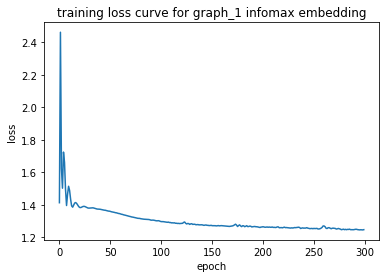

hateful_post_tn                      14065.000000
hateful_post_fp                       5746.000000
hateful_post_fn                        327.000000
hateful_post_tp                        545.000000
hateful_post_acc                         0.706377
hateful_post_auc                         0.667480
hateful_post_precision                   0.086632
hateful_post_recall                      0.625000
controversial_community_tn                    NaN
controversial_community_fp                    NaN
controversial_community_fn                    NaN
controversial_community_tp                    NaN
controversial_community_acc                   NaN
controversial_community_auc                   NaN
controversial_community_precision             NaN
controversial_community_recall                NaN
subreddit_community_acc                       NaN
Name: graph_1:infomax, dtype: float64

evaluating embeddings for graph_2
evaluating node2vec embedding for graph_2
training loss curve


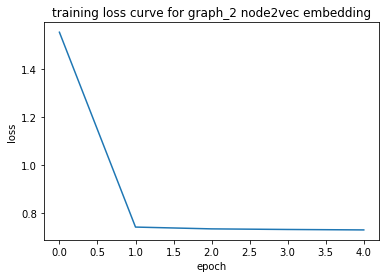

TSNE plot for the embedding
embedding seperated by hateful posts


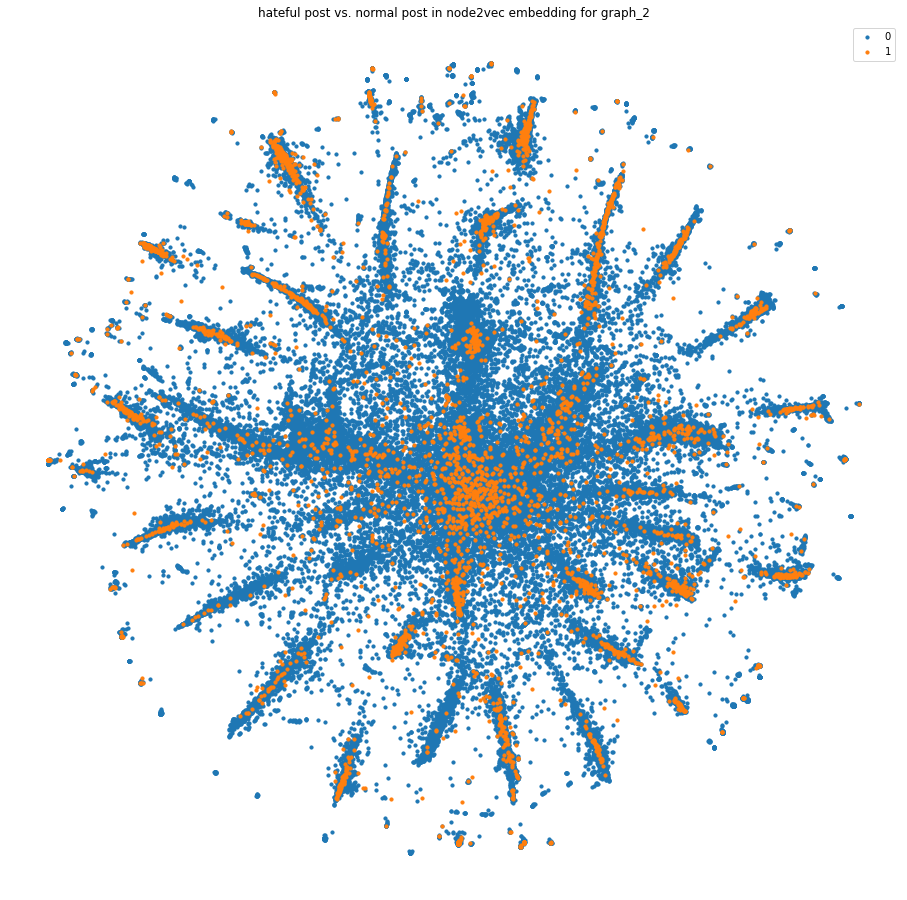

embedding seperated by controversial communities


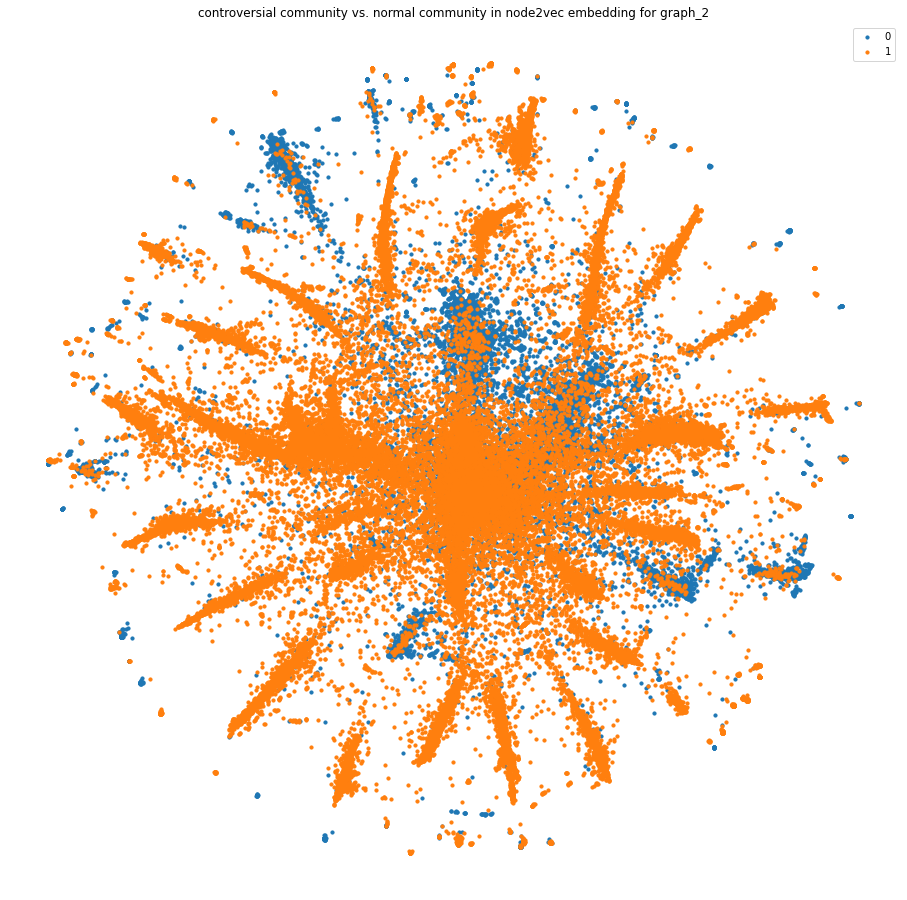

embedding seperated by subreddits


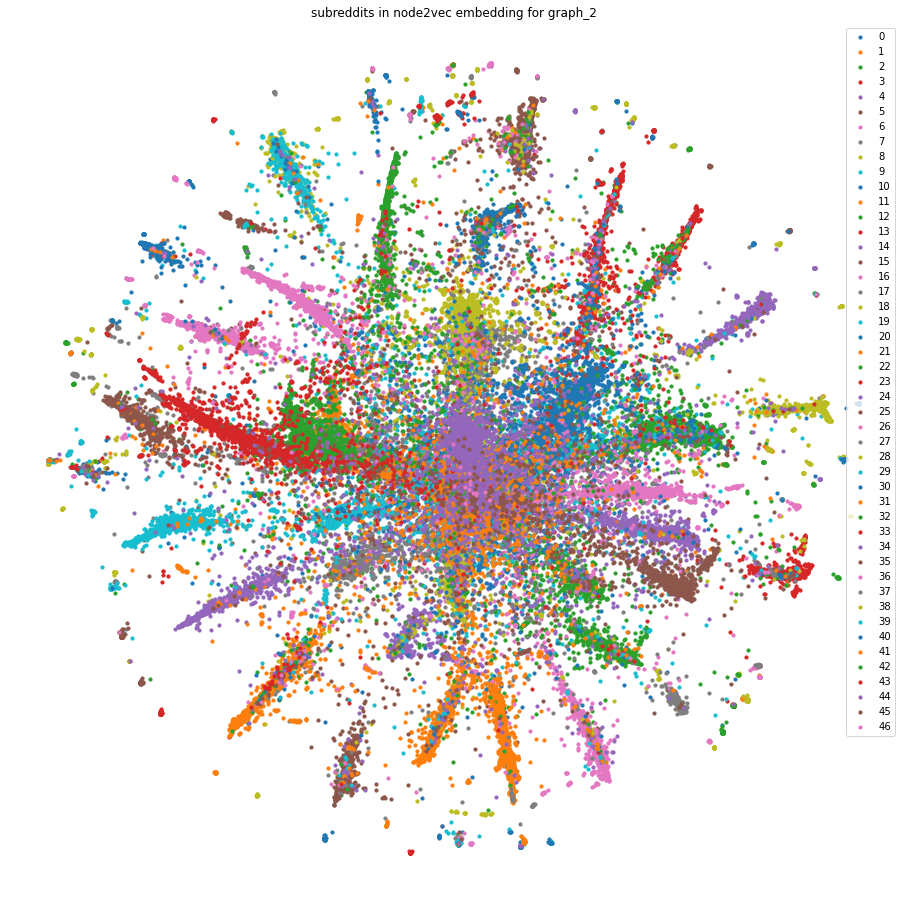

hateful_post_tn                      11889.000000
hateful_post_fp                       7922.000000
hateful_post_fn                        327.000000
hateful_post_tp                        545.000000
hateful_post_acc                         0.601170
hateful_post_auc                         0.612561
hateful_post_precision                   0.064368
hateful_post_recall                      0.625000
controversial_community_tn            3963.000000
controversial_community_fp             743.000000
controversial_community_fn            1962.000000
controversial_community_tp           14015.000000
controversial_community_acc              0.869216
controversial_community_auc              0.859657
controversial_community_precision        0.949654
controversial_community_recall           0.877198
subreddit_community_acc                  0.836436
Name: graph_2:node2vec, dtype: float64

evaluating metapath2vec embedding for graph_2
training loss curve


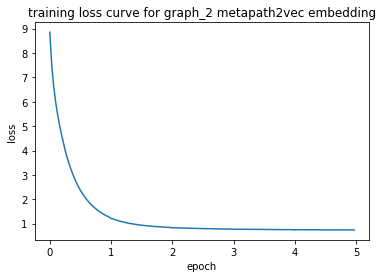

TSNE plot for the embedding
embedding seperated by hateful posts


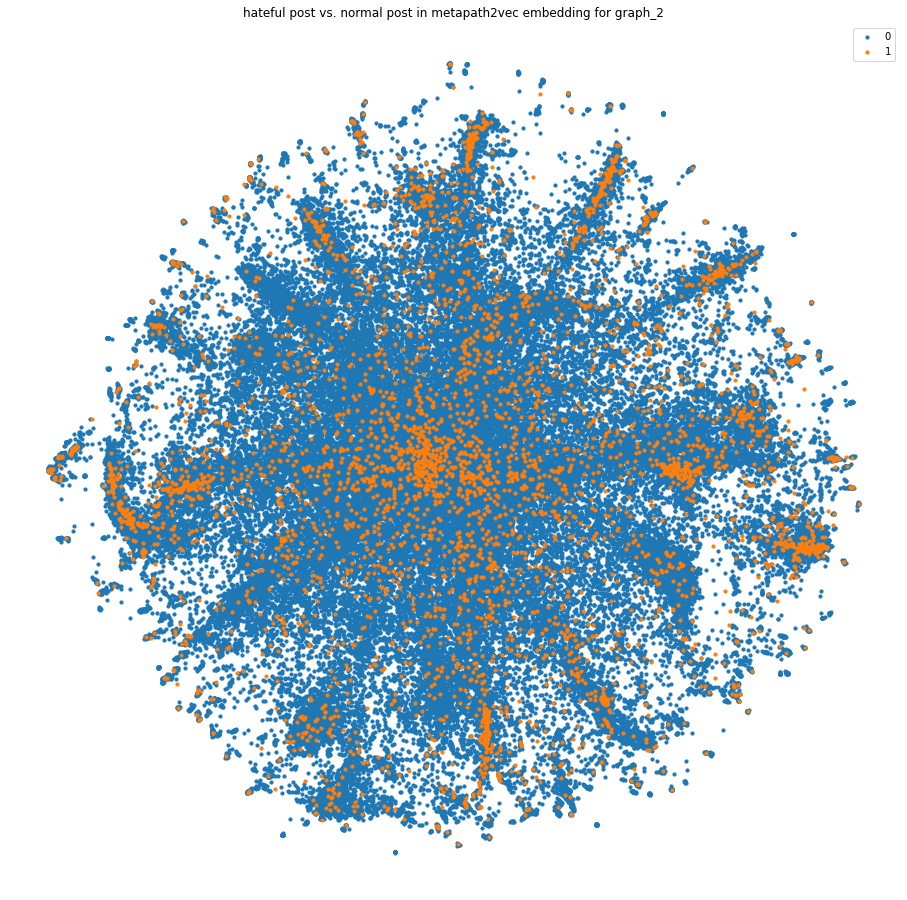

embedding seperated by controversial communities


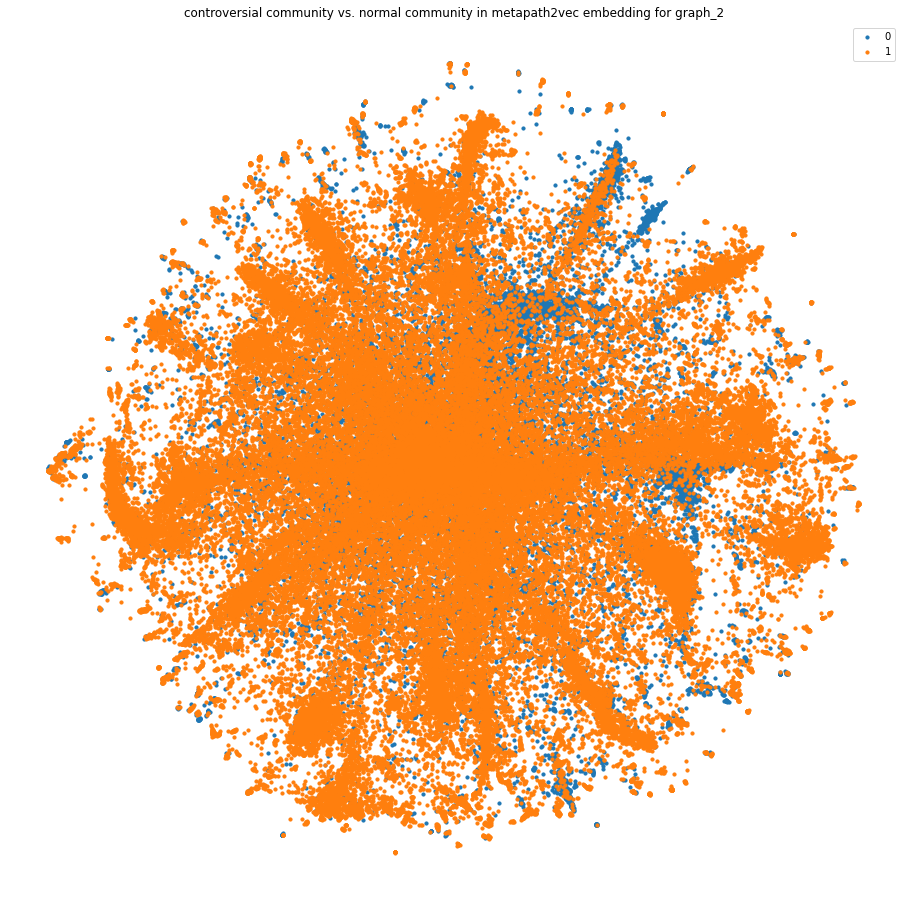

embedding seperated by subreddits


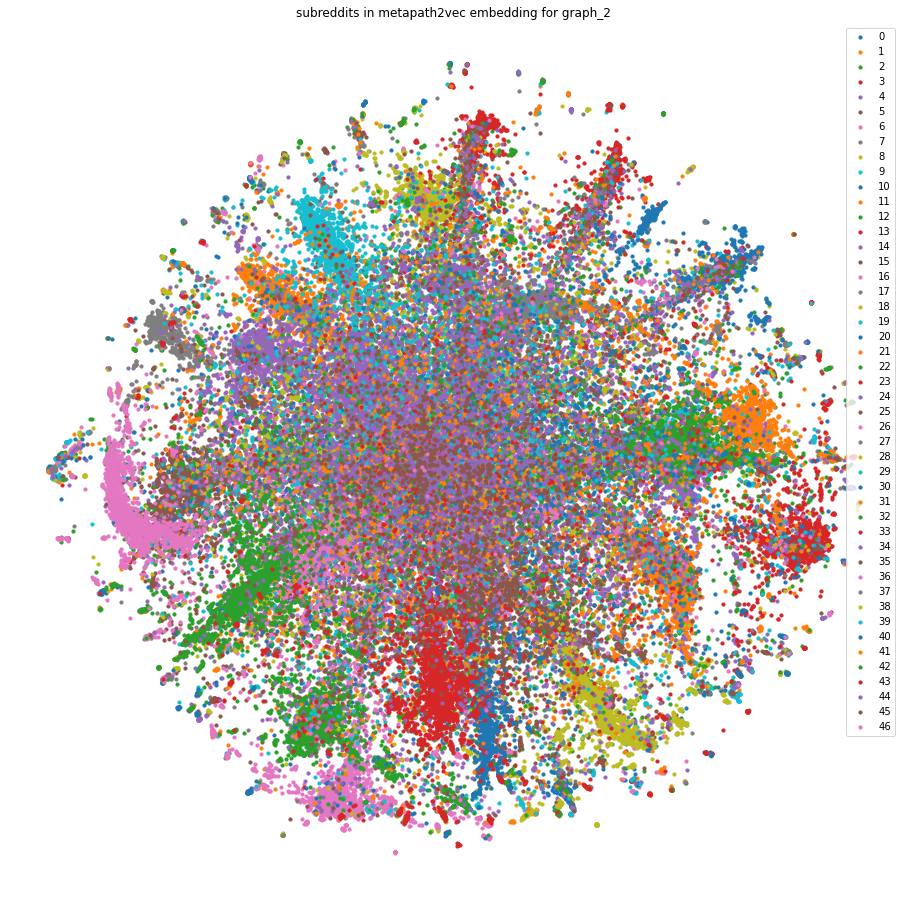

hateful_post_tn                      11635.000000
hateful_post_fp                       8176.000000
hateful_post_fn                        410.000000
hateful_post_tp                        462.000000
hateful_post_acc                         0.584876
hateful_post_auc                         0.558558
hateful_post_precision                   0.053485
hateful_post_recall                      0.529817
controversial_community_tn            3405.000000
controversial_community_fp            1301.000000
controversial_community_fn            3561.000000
controversial_community_tp           12416.000000
controversial_community_acc              0.764928
controversial_community_auc              0.750331
controversial_community_precision        0.905154
controversial_community_recall           0.777117
subreddit_community_acc                  0.640913
Name: graph_2:metapath2vec, dtype: float64

evaluating infomax embedding for graph_2
training loss curve


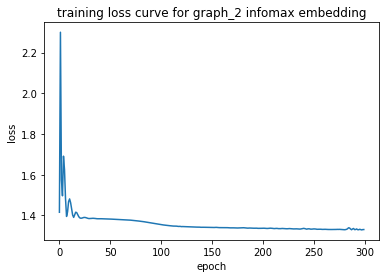

hateful_post_tn                      12934.000000
hateful_post_fp                       6877.000000
hateful_post_fn                        297.000000
hateful_post_tp                        575.000000
hateful_post_acc                         0.653145
hateful_post_auc                         0.656137
hateful_post_precision                   0.077160
hateful_post_recall                      0.659404
controversial_community_tn                    NaN
controversial_community_fp                    NaN
controversial_community_fn                    NaN
controversial_community_tp                    NaN
controversial_community_acc                   NaN
controversial_community_auc                   NaN
controversial_community_precision             NaN
controversial_community_recall                NaN
subreddit_community_acc                       NaN
Name: graph_2:infomax, dtype: float64

In [10]:
res = evaluate_embedding(fp)

In [15]:
display(res)

graph_1:node2vec  graph_1:metapath2vec  \
hateful_post_tn                        11963.000000          11838.000000   
hateful_post_fp                         7848.000000           7973.000000   
hateful_post_fn                          398.000000            400.000000   
hateful_post_tp                          474.000000            472.000000   
hateful_post_acc                           0.601315              0.595175   
hateful_post_auc                           0.573717              0.569416   
hateful_post_precision                     0.056957              0.055891   
hateful_post_recall                        0.543578              0.541284   
controversial_community_tn              3811.000000           3426.000000   
controversial_community_fp               895.000000           1280.000000   
controversial_community_fn              2835.000000           3366.000000   
controversial_community_tp             13142.000000          12611.000000   
controversial_community_acc                0.819659              0.775371   
controversial_community_auc                0.816187              0.758664   
controversial_community_precision          0.936240              0.907854   
controversial_community_recall             0.822557              0.789322   
subreddit_community_acc                    0.805154              0.702703   

                                   graph_1:infomax  graph_2:node2vec  \
hateful_post_tn                       14065.000000      11889.000000   
hateful_post_fp                        5746.000000       7922.000000   
hateful_post_fn                         327.000000        327.000000   
hateful_post_tp                         545.000000        545.000000   
hateful_post_acc                          0.706377          0.601170   
hateful_post_auc                          0.667480          0.612561   
hateful_post_precision                    0.086632          0.064368   
hateful_post_recall                       0.625000          0.625000   
controversial_community_tn                     NaN       3963.000000   
controversial_community_fp                     NaN        743.000000   
controversial_community_fn                     NaN       1962.000000   
controversial_community_tp                     NaN      14015.000000   
controversial_community_acc                    NaN          0.869216   
controversial_community_auc                    NaN          0.859657   
controversial_community_precision              NaN          0.949654   
controversial_community_recall                 NaN          0.877198   
subreddit_community_acc                        NaN          0.836436   

                                   graph_2:metapath2vec  graph_2:infomax  
hateful_post_tn                            11635.000000     12934.000000  
hateful_post_fp                             8176.000000      6877.000000  
hateful_post_fn                              410.000000       297.000000  
hateful_post_tp                              462.000000       575.000000  
hateful_post_acc                               0.584876         0.653145  
hateful_post_auc                               0.558558         0.656137  
hateful_post_precision                         0.053485         0.077160  
hateful_post_recall                            0.529817         0.659404  
controversial_community_tn                  3405.000000              NaN  
controversial_community_fp                  1301.000000              NaN  
controversial_community_fn                  3561.000000              NaN  
controversial_community_tp                 12416.000000              NaN  
controversial_community_acc                    0.764928              NaN  
controversial_community_auc                    0.750331              NaN  
controversial_community_precision              0.905154              NaN  
controversial_community_recall                 0.777117              NaN  
subreddit_community_acc                        0.640913              NaN

In [14]:
res.to_csv(osp.join(fp, 'processed', 'embedding_result.csv'))